In [30]:
import os
os.chdir("..")

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping, box, Point
from shapely.ops import unary_union
from rasterio.features import geometry_mask
from affine import Affine
import geopandas as gpd
from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptiveStratifiedSampler

In [32]:
denton = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/config.json")

In [10]:
denton_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/Denton_fullmonte_depths.pq")

In [11]:
rng = np.random.default_rng(42)  # reproducible run (optional)

sampler = AdaptiveStratifiedSampler(
    data=denton,
    nx0=15, ny0=10,            # initial 10×10 grid
    B=500,                     # samples per iteration (fixed pool)
    K_split=5,                 # split up to 5 parents each iter (quad each)
    n_min_to_split=3,
    max_depth=20,
    temper_alpha=0.8,
    floor_min1=True,

    # distance-to-watershed prior (optional):
    prior_sigma=15000,         # decay length in CRS units (e.g., meters)
    prior_floor=0.3,           # far cells still keep ≥30% weight
    prior_alpha=0.8,           # strength at t=1
    prior_anneal_iters=5       # fade to zero by iter 5
) 

In [12]:
samples, grids_by_rep = sampler.run(
    n_iters=20,        # iterations per repetition
    n_rep=50,         # number of repetitions
    rng=rng,          # optional RNG
    compute_weights=True  # fills samples['w_uniform'] per repetition
)

/workspaces/Importance-Sampling-for-SST/SSTImportanceSampling/stratifiedsampler.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.samples = pd.concat([self.samples, new_pts], ignore_index=True)


In [13]:
import geopandas as gpd

A_domain = float(sampler.domain_geom.area)
rows = []

for r, snaps in enumerate(sampler.grids_by_rep, start=1):
    if not snaps:
        continue
    final_gdf = snaps[-1].copy()

    # Keep only active leaves to avoid parent–child overlap
    if "active" in final_gdf.columns:
        final_gdf = final_gdf[final_gdf["active"]].copy()

    pts = samples.loc[samples["rep"]==r, ["sample_id","x","y"]].dropna()
    if pts.empty:
        continue

    gdf_pts = gpd.GeoDataFrame(
        pts, geometry=gpd.points_from_xy(pts["x"], pts["y"]), crs=final_gdf.crs
    )

    # 'within' is stricter; with active (disjoint) cells you get 1 match per point
    joined = gpd.sjoin(gdf_pts, final_gdf[["leaf_id","area_in_domain","geometry"]],
                       how="left", predicate="within").dropna(subset=["leaf_id"])

    # Sanity: enforce unique sample match
    joined = (joined.sort_values(["sample_id"])
                    .drop_duplicates("sample_id", keep="first"))

    counts = joined.groupby("leaf_id").size().rename("n_leaf").reset_index()
    counts = counts.merge(final_gdf[["leaf_id","area_in_domain"]], on="leaf_id", how="left")

    N_rep = int(len(joined))
    counts["w_leaf"] = (counts["area_in_domain"] / A_domain) * (N_rep / counts["n_leaf"])

    w_map = counts.set_index("leaf_id")["w_leaf"]
    joined["w_uniform_fix"] = joined["leaf_id"].map(w_map).astype(float)

    rows.append(joined[["sample_id","w_uniform_fix"]])

weights_fix = pd.concat(rows, ignore_index=True)

# Merge back (one-to-one on sample_id)
samples = (samples
           .drop(columns=["w_uniform"], errors="ignore")
           .merge(weights_fix, on="sample_id", how="left", validate="one_to_one")
           .rename(columns={"w_uniform_fix":"w_uniform"}))

In [14]:
import numpy as np
import pandas as pd

lam = 10.0  # storms per year (Langbein/Poisson)

# Build per-rep tail tables
pieces = []
for rep_id, g in samples.groupby("rep", sort=True):
    d = g.loc[:, ["sample_id", "g", "w_uniform"]].dropna(subset=["g", "w_uniform"]).copy()
    if d.empty:
        continue

    # normalize weights within this rep
    d["w"] = d["w_uniform"].astype(float).clip(lower=0.0)
    W = d["w"].sum()
    d["w_norm"] = (d["w"] / W) if W > 0 else (1.0 / len(d))

    # sort by depth (high→low) and build exceedance
    d = d.sort_values("g", ascending=False).reset_index(drop=True)
    d["excprb"] = d["w_norm"].cumsum().clip(upper=1.0)

    # return period from AEP = 1 - exp(-lam * excprb)
    AEP = 1.0 - np.exp(-lam * d["excprb"].values)
    d["RP"] = 1.0 / np.maximum(AEP, 1e-12)

    d["rep"] = rep_id
    pieces.append(d.loc[:, ["sample_id", "rep", "excprb", "RP"]])

# Attach back to master samples
per_rep_tail = pd.concat(pieces, ignore_index=True) if pieces else pd.DataFrame(columns=["sample_id","rep","excprb","RP"])
samples = (samples
           .drop(columns=["excprb","RP"], errors="ignore")
           .merge(per_rep_tail, on=["sample_id","rep"], how="left"))

# Optional: per-rep sorted tables ready for plotting
tail_tables_by_rep = {r: t.sort_values("RP") for r, t in per_rep_tail.groupby("rep")}

In [17]:
import numpy as np
import pandas as pd

# Expect in `samples`: columns ['rep','RP','g']
df = samples.loc[:, ['rep','RP','g']].dropna().copy()
df = df[(df['RP'] > 0) & np.isfinite(df['RP']) & np.isfinite(df['g'])]

# Integer return-period grid
rp_years = np.arange(2, 2001, 1, dtype=float)

rows = []
for rep_id, g in df.groupby('rep', sort=True):
    # sort by RP and dedupe; keep last depth at duplicate RP
    gg = (g.sort_values('RP')
           .drop_duplicates('RP', keep='last')
           .copy())
    rp = gg['RP'].to_numpy(float)
    y  = gg['g'].to_numpy(float)

    ok = np.isfinite(rp) & np.isfinite(y) & (rp > 0)
    rp, y = rp[ok], y[ok]

    if rp.size < 2:
        y_interp = np.full_like(rp_years, np.nan, dtype=float)
    else:
        # enforce non-decreasing depth with RP (optional but recommended)
        y = np.maximum.accumulate(y)
        # **Linear** interpolation in RP space; outside-range → NaN
        y_interp = np.interp(rp_years, rp, y, left=np.nan, right=np.nan)

    rows.append(pd.DataFrame({
        'rep': rep_id,
        'year': rp_years,
        'g_interp': y_interp
    }))

per_rep_yearly = pd.concat(rows, ignore_index=True)

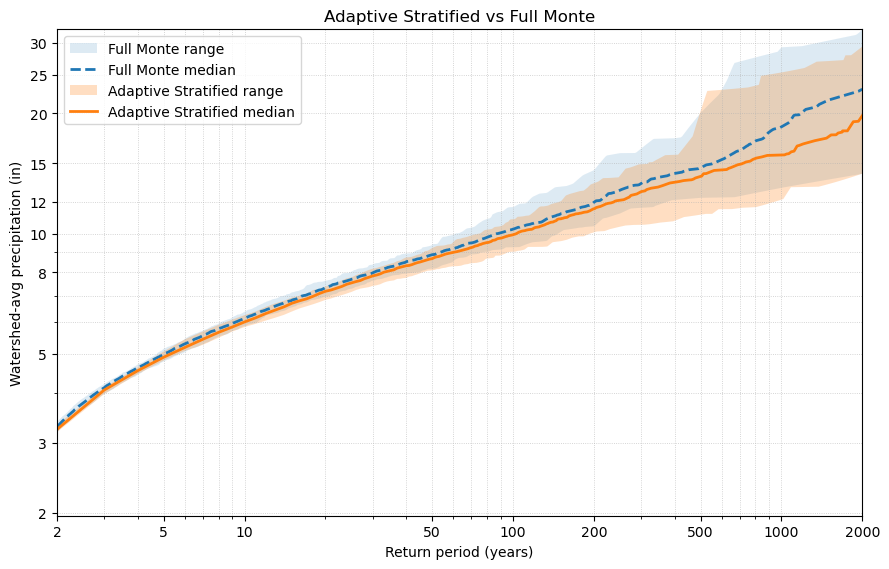

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MM_TO_IN = 1.0 / 25.4  # convert mm → inches

# =========================
# Adaptive Stratified block
# =========================
# per_rep_yearly: ['rep','year','g_interp'] where g_interp is in mm
dfy = per_rep_yearly.loc[:, ['rep','year','g_interp']].dropna().copy()
dfy = dfy[(dfy['year'] >= 2) & (dfy['year'] <= 2000) & (dfy['g_interp'] > 0) & np.isfinite(dfy['g_interp'])]

grp = dfy.groupby('year', sort=True)['g_interp']
stats = grp.agg(
    n      = lambda s: np.isfinite(s).sum(),
    median = lambda s: np.nanmedian(s.to_numpy()),
    low    = lambda s: np.nanmin(s.to_numpy()),
    high   = lambda s: np.nanmax(s.to_numpy())
).reset_index()

nreps = dfy['rep'].nunique()
min_reps = max(3, int(np.ceil(0.5 * nreps)))
maskA = (stats['n'] >= min_reps) & np.isfinite(stats['median']) & (stats['median'] > 0) \
        & np.isfinite(stats['low']) & (stats['low'] > 0) & np.isfinite(stats['high']) & (stats['high'] > 0)

years_A   = stats.loc[maskA, 'year'].to_numpy(float)
median_Ai = stats.loc[maskA, 'median'].to_numpy(float) * MM_TO_IN
low_Ai    = stats.loc[maskA, 'low'].to_numpy(float)    * MM_TO_IN
high_Ai   = stats.loc[maskA, 'high'].to_numpy(float)   * MM_TO_IN

# Enforce non-decreasing Adaptive median w.r.t. RP
median_Ai = np.maximum.accumulate(median_Ai)

# ==================
# Full Monte block
# ==================
dfM = denton_fullmonte_depths.loc[:, ['rep','return_period','precip_avg_mm']].dropna().copy()
dfM = dfM[(dfM['return_period'] > 0) & (dfM['precip_avg_mm'] > 0)
          & np.isfinite(dfM['return_period']) & np.isfinite(dfM['precip_avg_mm'])]

rp_grid = np.geomspace(2.0, 2000.0, 600)

def interp_curve_M(g: pd.DataFrame) -> np.ndarray:
    g = g.sort_values('return_period').drop_duplicates('return_period', keep='last')
    rp = g['return_period'].to_numpy(float)
    depth = g['precip_avg_mm'].to_numpy(float) * MM_TO_IN  # convert to inches
    ok = np.isfinite(rp) & np.isfinite(depth) & (rp > 0) & (depth > 0)
    rp, depth = rp[ok], depth[ok]
    if rp.size < 2:
        return np.full_like(rp_grid, np.nan, dtype=float)
    return np.interp(np.log(rp_grid), np.log(rp), depth, left=np.nan, right=np.nan)

curves_M = []
for _, g in dfM.groupby('rep', sort=True):
    curves_M.append(interp_curve_M(g))
curves_M = np.vstack(curves_M) if len(curves_M) else np.full((1, rp_grid.size), np.nan)

median_Mi = np.nanmedian(curves_M, axis=0)
low_Mi    = np.nanmin(curves_M, axis=0)
high_Mi   = np.nanmax(curves_M, axis=0)

m_spread_M = np.isfinite(low_Mi) & np.isfinite(high_Mi) & (low_Mi > 0) & (high_Mi > 0)
m_med_M    = np.isfinite(median_Mi) & (median_Mi > 0)

# ==================
# Shared plot (inches)
# ==================
fig, ax = plt.subplots(figsize=(9, 5.8))

# Full Monte (dashed)
if np.any(m_spread_M):
    ax.fill_between(rp_grid[m_spread_M], low_Mi[m_spread_M], high_Mi[m_spread_M],
                    alpha=0.15, label='Full Monte range')
if np.any(m_med_M):
    ax.plot(rp_grid[m_med_M], median_Mi[m_med_M], linewidth=2.0, linestyle='--', label='Full Monte median')

# Adaptive (solid)
if years_A.size:
    ax.fill_between(years_A, low_Ai, high_Ai, alpha=0.25, label='Adaptive Stratified range')
    ax.plot(years_A, median_Ai, linewidth=2.0, label='Adaptive Stratified median')

# Axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2, 2000)

# Y range (inches)
candidates = []
if np.any(m_spread_M): candidates.append(np.nanmax(high_Mi[m_spread_M]))
if years_A.size:       candidates.append(np.nanmax(high_Ai))
ymax_in = float(np.nanmax(candidates)) if candidates else 4.0
ymin_in = 50.0 * MM_TO_IN  # ~2 inches, to mirror earlier 50 mm lower bound
ymax_in = max(ymax_in, ymin_in*1.1)
ax.set_ylim(ymin_in, ymax_in)
ax.autoscale(enable=False, axis='y')

# Ticks
xticks = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000], dtype=float)
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])

# Nice inch ticks for log-y
inch_candidates = np.array([1, 2, 3, 5, 8, 10, 12, 15, 20, 25, 30, 40, 50], dtype=float)
yticks = inch_candidates[(inch_candidates >= ymin_in) & (inch_candidates <= ymax_in)]
if yticks.size == 0: yticks = np.array([ymin_in, ymax_in])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{t:g}" for t in yticks])

ax.set_xlabel('Return period (years)')
ax.set_ylabel('Watershed-avg precipitation (in)')
ax.set_title('Adaptive Stratified vs Full Monte')
ax.grid(True, which='both', linestyle=':', linewidth=0.6, alpha=0.7)
ax.legend()
fig.tight_layout()
plt.show()

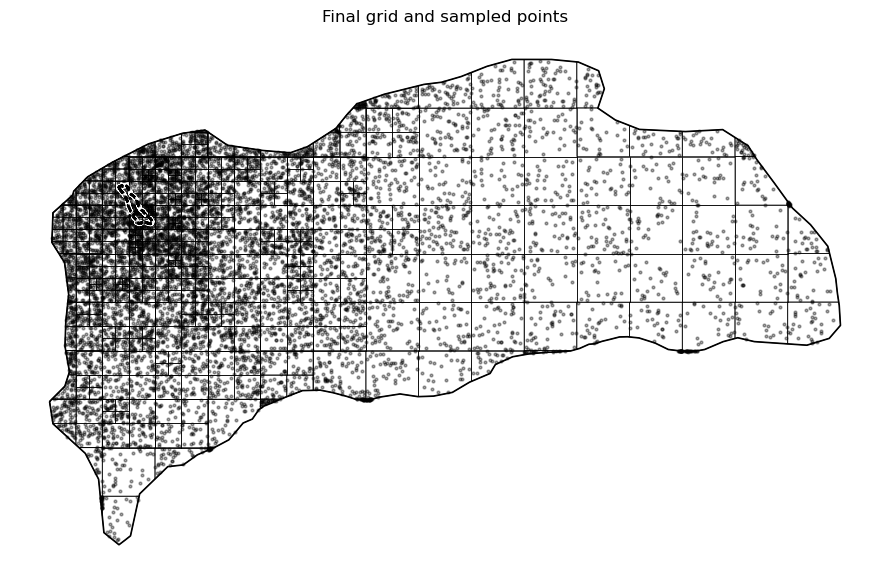

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# --- Final grid GeoDataFrame ---
if len(sampler.grids_by_rep[1]) > 0:
    final_gdf = sampler.grids_by_rep[1][-1].copy()
else:
    # build from current leaves if no snapshots were stored
    polys = [box(r.x_min, r.y_min, r.x_max, r.y_max) for _, r in sampler.leaves.iterrows()]
    final_gdf = gpd.GeoDataFrame(sampler.leaves.copy(), geometry=polys, crs=sampler.domain_gdf.crs)
    final_gdf["geometry"] = final_gdf.geometry.intersection(sampler.domain_geom)
    final_gdf = final_gdf[~final_gdf.geometry.is_empty & final_gdf.geometry.notnull()].copy()

# --- All samples as a GeoDataFrame ---
pts_df = sampler.samples.loc[sampler.samples["rep"].isin([2]), ["x","y"]].dropna()
gdf_pts = gpd.GeoDataFrame(
    pts_df,
    geometry=gpd.points_from_xy(pts_df["x"], pts_df["y"]),
    crs=sampler.domain_gdf.crs
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 9))

# Domain & watershed (black outlines)
sampler.domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2)
sampler.watershed_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2, linestyle="--")

# Final grid as thin black outlines
final_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

# All sampled points as small, semi-transparent black dots
if not gdf_pts.empty:
    ax.scatter(gdf_pts.geometry.x, gdf_pts.geometry.y, s=4, c="black", alpha=0.35)

# Overlay watershed AGAIN so it pops on top (white halo + black dashed)
sampler.watershed_gdf.boundary.plot(ax=ax, color="white", linewidth=3.2, linestyle="--", zorder=5)
sampler.watershed_gdf.boundary.plot(ax=ax, color="black", linewidth=1.8, linestyle="--", zorder=6)

# Clean axes (no grid, no ticks, no spines)
ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Final grid and sampled points", pad=10)
plt.tight_layout()
plt.show()


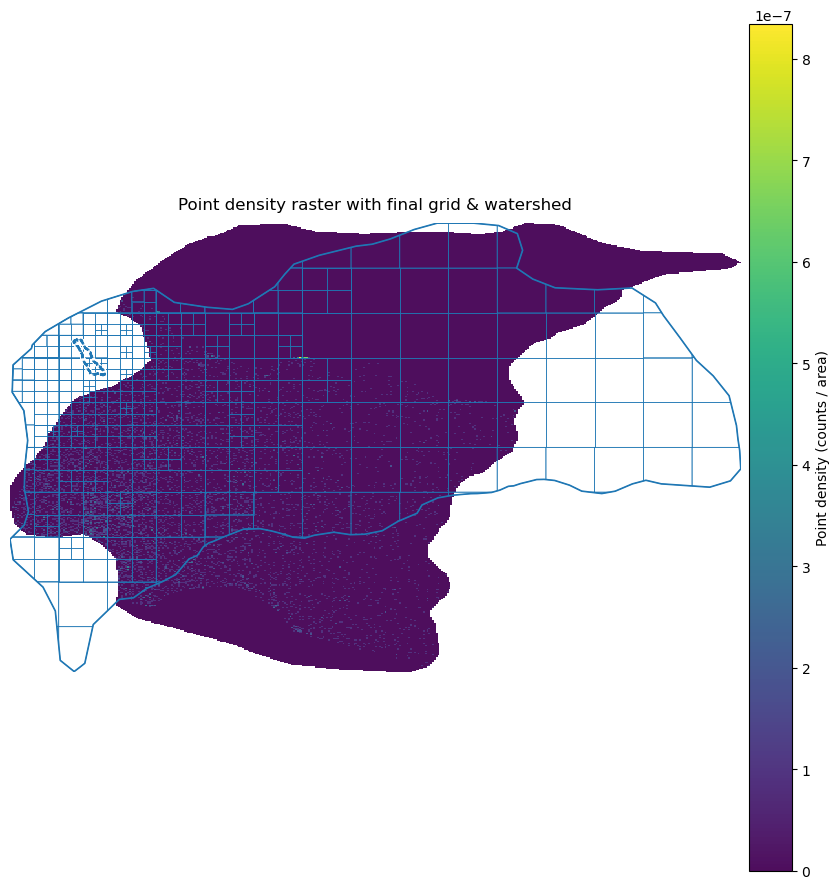

In [27]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# ---------- Build/choose the final grid ----------
if len(sampler.grids_by_rep[1]) > 0:
    final_gdf = sampler.grids_by_rep[1][-1].copy()
else:
    from shapely.geometry import box
    polys = [box(r.x_min, r.y_min, r.x_max, r.y_max) for _, r in sampler.leaves.iterrows()]
    final_gdf = gpd.GeoDataFrame(sampler.leaves.copy(), geometry=polys, crs=sampler.domain_gdf.crs)
    final_gdf["geometry"] = final_gdf.geometry.intersection(sampler.domain_geom)
    final_gdf = final_gdf[~final_gdf.geometry.is_empty & final_gdf.geometry.notnull()].copy()

# ---------- Points to rasterize density from (choose your reps) ----------
pts_df = sampler.samples.loc[sampler.samples["rep"].isin([2]), ["x","y"]].dropna()
gdf_pts = gpd.GeoDataFrame(
    pts_df,
    geometry=gpd.points_from_xy(pts_df["x"], pts_df["y"]),
    crs=sampler.domain_gdf.crs
)

if gdf_pts.empty:
    raise ValueError("No points to rasterize. Check your rep filter or sampling step.")

# ---------- Make a raster grid covering the domain ----------
xmin, ymin, xmax, ymax = sampler.domain_geom.bounds

# Resolution of the output raster (increase for finer detail)
nx, ny = 400, 400

# 2D histogram (counts per pixel)
H, xedges, yedges = np.histogram2d(
    gdf_pts.geometry.x.to_numpy(),
    gdf_pts.geometry.y.to_numpy(),
    bins=[nx, ny],
    range=[[xmin, xmax], [ymin, ymax]]
)

# Area-normalized density (points per unit area), optional
dx = (xmax - xmin) / nx
dy = (ymax - ymin) / ny
H_density = H / (dx * dy)  # comment this out if you only want counts

# ---------- Mask to the domain polygon ----------
# Build a georeferencing transform that matches our histogram grid
transform = from_bounds(xmin, ymin, xmax, ymax, nx, ny)

# Rasterize domain polygon: 1 inside domain, 0 outside
domain_mask = rasterize(
    [(sampler.domain_geom, 1)],
    out_shape=(ny, nx),              # (rows, cols)
    transform=transform,
    fill=0
).astype(bool)

# Apply mask (NaN outside domain)
R = H_density.copy()                # or use H if you want counts
R[~domain_mask] = np.nan

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(9, 9))

# Show the raster (transpose so x~cols, y~rows; origin lower for natural coords)
im = ax.imshow(
    np.flipud(R.T),                      # flip upside down after transpose
    origin="lower",
    extent=[xmin, xmax, ymin, ymax],
    interpolation="nearest",
    alpha=0.95
)
cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.set_label("Point density (counts / area)")  # change to "Point count" if using H

# Overlays: domain, watershed, and final grid
sampler.domain_gdf.boundary.plot(ax=ax, linewidth=1.2)
sampler.watershed_gdf.boundary.plot(ax=ax, linewidth=1.2, linestyle="--")
final_gdf.boundary.plot(ax=ax, linewidth=0.5)

# Halo the watershed so it pops
sampler.watershed_gdf.boundary.plot(ax=ax, color="white", linewidth=3.0, linestyle="--", zorder=5)
sampler.watershed_gdf.boundary.plot(ax=ax, linewidth=1.6, linestyle="--", zorder=6)

# Clean axes
ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])
for sp in ax.spines.values():
    sp.set_visible(False)
ax.set_title("Point density raster with final grid & watershed", pad=10)

plt.tight_layout()
plt.show()



In [20]:
# Interpolate Adaptive median to rp_grid
median_Ai_interp = np.interp(np.log(rp_grid), np.log(years_A), median_Ai,
                             left=np.nan, right=np.nan)

# Mask finite overlapping points
mask_med = np.isfinite(median_Ai_interp) & np.isfinite(median_Mi)
rmse_median = np.sqrt(np.nanmean((median_Ai_interp[mask_med] - median_Mi[mask_med])**2))
print("RMSE (median):", rmse_median)

RMSE (median): 1.3044834145094313


In [23]:
# Interpolate Adaptive low/high to rp_grid
low_Ai_interp  = np.interp(np.log(rp_grid), np.log(years_A), low_Ai,
                           left=np.nan, right=np.nan)
high_Ai_interp = np.interp(np.log(rp_grid), np.log(years_A), high_Ai,
                           left=np.nan, right=np.nan)

# Masks
mask_low  = np.isfinite(low_Ai_interp)  & np.isfinite(low_Mi)
mask_high = np.isfinite(high_Ai_interp) & np.isfinite(high_Mi)

rmse_low  = np.sqrt(np.nanmean((low_Ai_interp[mask_low] - low_Mi[mask_low])**2))
rmse_high = np.sqrt(np.nanmean((high_Ai_interp[mask_high] - high_Mi[mask_high])**2))

print("RMSE (low bounds):", rmse_low)
print("RMSE (high bounds):", rmse_high)

RMSE (low bounds): 0.5269425366318785
RMSE (high bounds): 1.5957712129074422


In [28]:
import pandas as pd
storms = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/storms.pq")

In [29]:
storms

,storm_path,x,y,storm_type,storm_date,basin_path,storm_id,storm_duration,storm_realization
event_number,,,,,,,,,
1,20210429_72hr_st1_r404.dss,30953.060874,8.147619e+05,st1,19921122,data/basinmodels/1992-11-22_trinity_may_jun_2015,20210429,72hr,r404.dss
2,20081110_72hr_st1_r403.dss,110953.060874,8.987619e+05,st1,19921129,data/basinmodels/1992-11-29_trinity_nov_dec_2015,20081110,72hr,r403.dss
3,20210517_72hr_st5_r391.dss,-245046.939126,8.307619e+05,st5,19910530,data/basinmodels/1991-05-30_trinity_may_jun_2015,20210517,72hr,r391.dss
4,20110903_72hr_st2_r015.dss,-25046.939126,6.747619e+05,st2,19951011,data/basinmodels/1995-10-11_trinity_may_jun_2015,20110903,72hr,r015.dss
5,19820201_72hr_st1_r247.dss,962953.060874,9.627619e+05,st1,20200202,data/basinmodels/2020-02-02_trinity_nov_dec_2015,19820201,72hr,r247.dss
...,...,...,...,...,...,...,...,...,...
19996,19821006_72hr_st1_r147.dss,-125046.939126,9.987619e+05,st1,20130130,data/basinmodels/2013-01-30_trinity_oct_nov_2015,19821006,72hr,r147.dss
19997,20221124_72hr_st5_r253.dss,-13046.939126,1.126762e+06,st5,20031030,data/basinmodels/2003-10-30_trinity_aug_sep_2017,20221124,72hr,r253.dss
19998,19900117_72hr_st1_r044.dss,-169046.939126,1.074762e+06,st1,19851114,data/basinmodels/1985-11-14_trinity_apr_may_1990,19900117,72hr,r044.dss


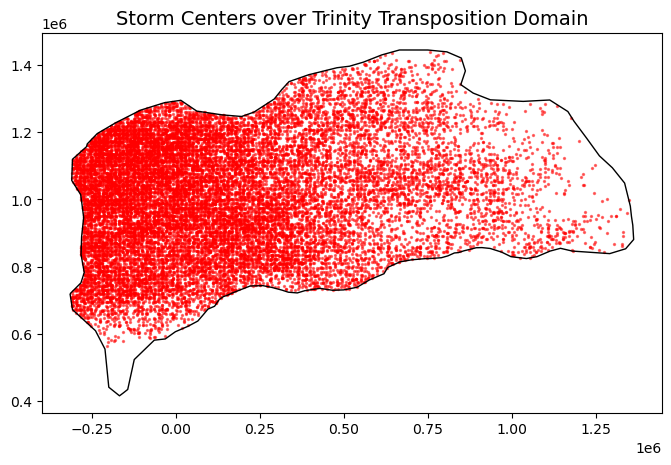

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- Load your storms DataFrame (already created from your screenshot) ---
# assuming storms is your DataFrame with x and y columns
storms_gdf = gpd.GeoDataFrame(
    storms,
    geometry=gpd.points_from_xy(storms["x"], storms["y"]),
    crs="EPSG:5070"   # change if your domain uses a different CRS
)

# --- Load Trinity domain shapefile (replace with actual path) ---
domain = denton.domain_gdf  # <- your polygon

# Reproject to match CRS if needed
if storms_gdf.crs != domain.crs:
    storms_gdf = storms_gdf.to_crs(domain.crs)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))
domain.boundary.plot(ax=ax, color="black", linewidth=1)
storms_gdf.plot(ax=ax, markersize=2, color="red", alpha=0.5)

ax.set_title("Storm Centers over Trinity Transposition Domain", fontsize=14)
plt.show()